### IMPORT/INSTALL PACKAGES

In [ ]:
!pip install pmdarima

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose

# Load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.ar_model import AR,ARResults
#from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### CUSTOM FUNCTION

In [2]:
# Method To Plot Graph For Data
def plotTimeSeriesGraph(dataframe, noOfcolumnsToPlot, setFigSize):
    values = dataframe.values
    # specify columns to plot
    #groups = [0, 1, 2, 3, 5, 6, 7]
    i = 1
    # plot each column
    plt.figure(figsize = setFigSize)
    for column in range(noOfcolumnsToPlot):
        plt.subplot(noOfcolumnsToPlot, 1, i)
        plt.plot(values[:, column])
        plt.title(dataframe.columns[column], y=0.5, loc='right')
        i += 1
    plt.show()

# Method To Perform Augmented Dickey-Fuller Test
def adf_test(series,title=''):
  """
  Pass in a time series and an optional title, returns an ADF report
  """
  print(f'Augmented Dickey-Fuller Test: {title}')
  result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
  
  labels = ['ADF test statistic','p-value','# lags used','# observations']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'critical value ({key})']=val
      
  print(out.to_string())          # .to_string() removes the line "dtype: float64"
  
  if result[1] <= 0.05:
      print("Strong evidence against the null hypothesis")
      print("Reject the null hypothesis")
      print("Data has no unit root and is stationary")
  else:
      print("Weak evidence against the null hypothesis")
      print("Fail to reject the null hypothesis")
      print("Data has a unit root and is non-stationary")

### GLOBAL VARIABLES

In [3]:
mainFolder = '/content/drive/My Drive/Data Science Projects/Application Energy Prediction/'
datasetsPath = mainFolder + 'Datasets/'
dataPath = datasetsPath + '2019Floor1.csv'
chekpointPath = mainFolder + 'Checkpoints/'

### EXPLORATORY DATA ANALYSIS

#### Read Data

In [4]:
df = pd.read_csv(dataPath,index_col='Date', parse_dates=True)
df.index.freq = 'min'

#### Remove Nan Values

In [5]:
# Removing NaN values from the dataset by filling appropriate values in those empty cells instead of dropping those rows.
from sklearn.impute import SimpleImputer as Im
imputer = Im(missing_values = np.nan, strategy = "mean")
im = imputer.fit(df.iloc[:, :])
df.iloc[:, :] = im.transform(df.iloc[:, :])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2019-01-01 00:00:00 to 2019-12-31 23:59:00
Freq: T
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   z1_Light(kW)  525600 non-null  float64
 1   z1_Plug(kW)   525600 non-null  float64
 2   z2_AC1(kW)    525600 non-null  float64
 3   z2_AC2(kW)    525600 non-null  float64
 4   z2_AC3(kW)    525600 non-null  float64
 5   z2_AC4(kW)    525600 non-null  float64
 6   z2_Light(kW)  525600 non-null  float64
 7   z2_Plug(kW)   525600 non-null  float64
 8   z3_Light(kW)  525600 non-null  float64
 9   z3_Plug(kW)   525600 non-null  float64
 10  z4_Light(kW)  525600 non-null  float64
dtypes: float64(11)
memory usage: 48.1 MB


#### Plot Data To Visualize

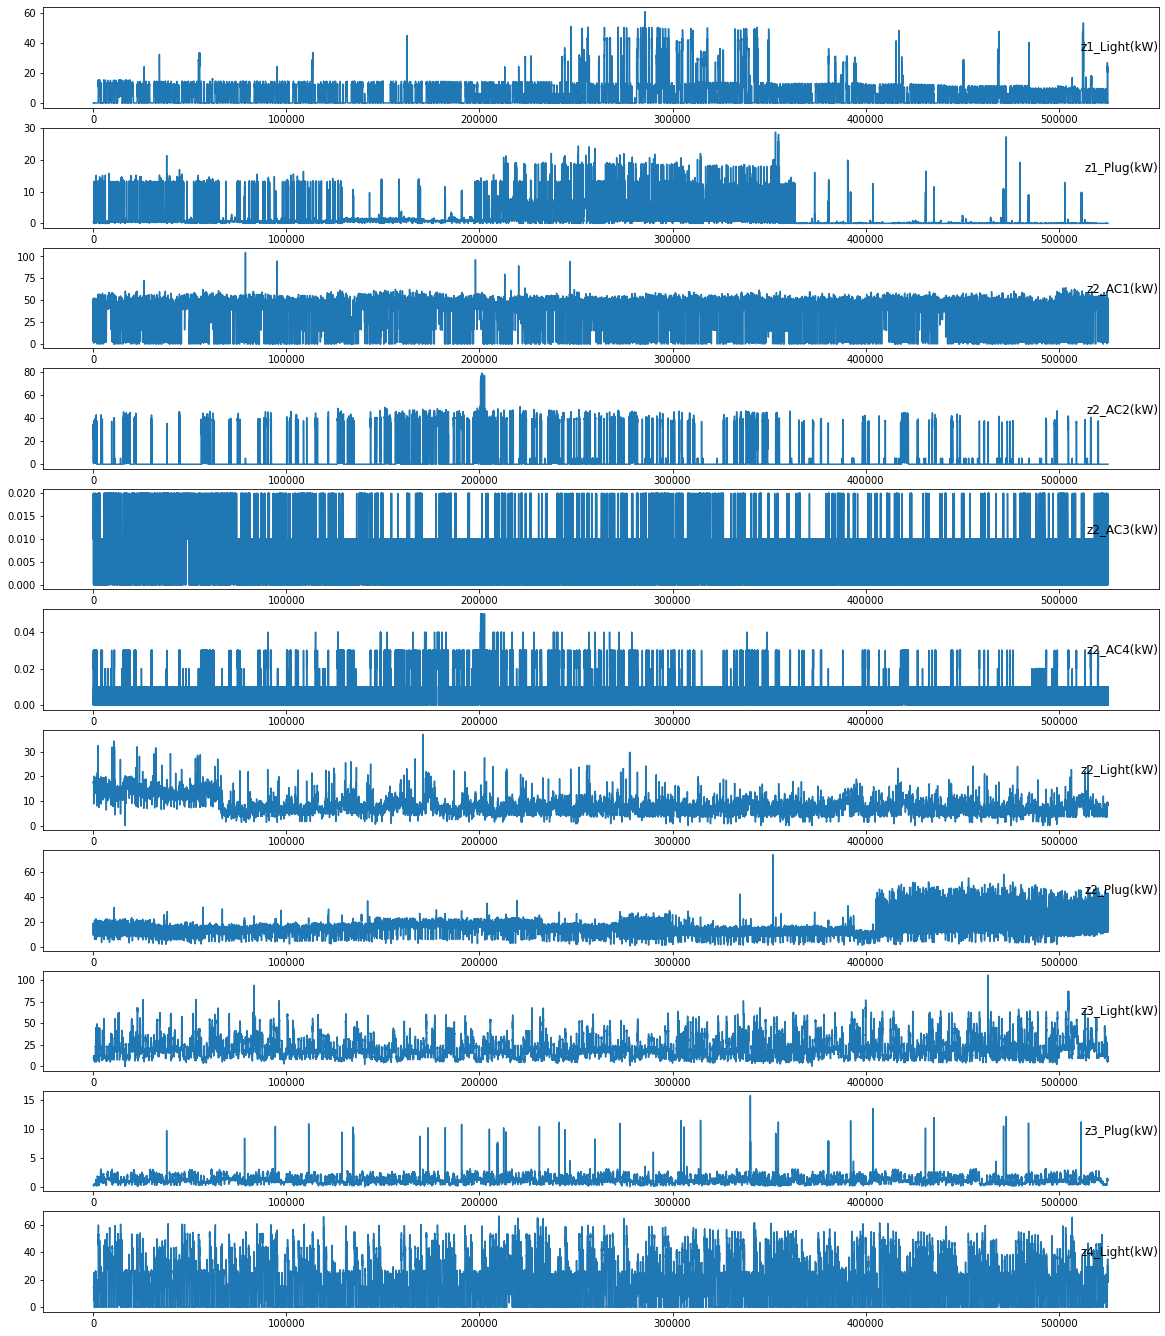

In [8]:
noOfcolumnsToPlot = 11
setFigSize = (20,24)
plotTimeSeriesGraph(df, noOfcolumnsToPlot, setFigSize)

#### Plot Seasonal Decomposition

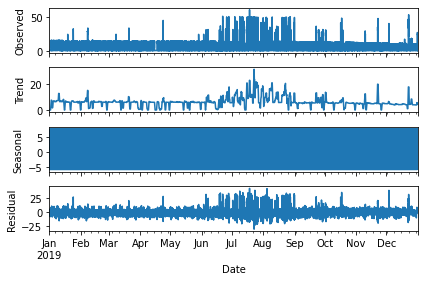

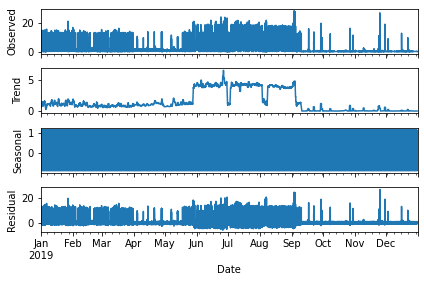

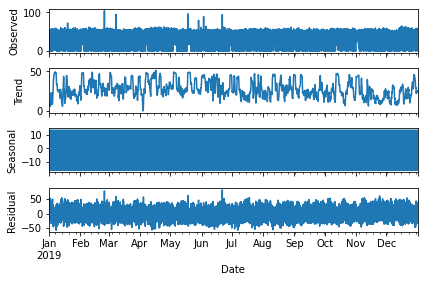

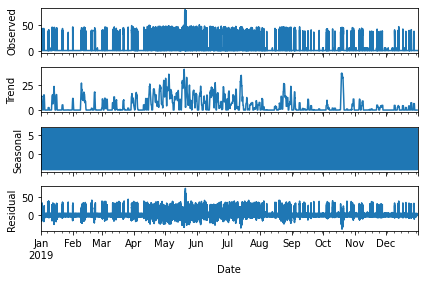

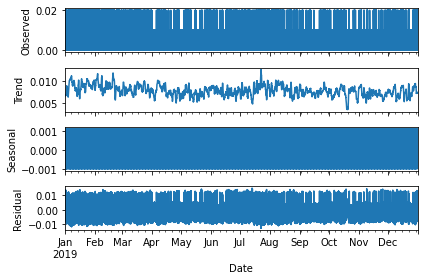

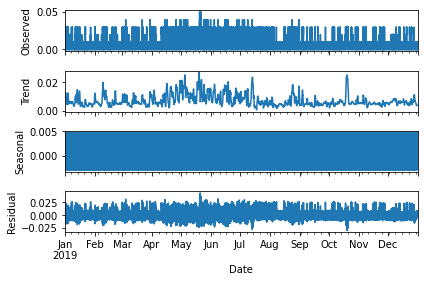

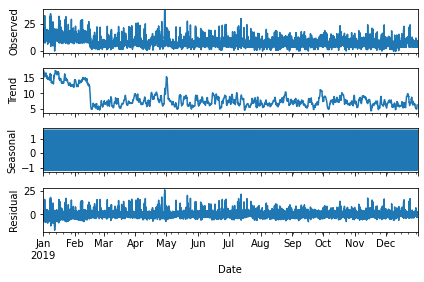

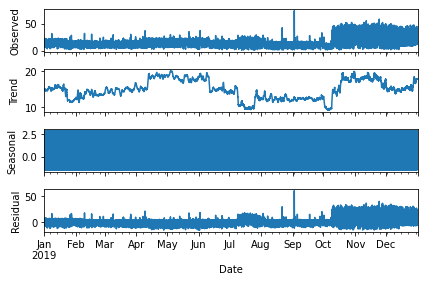

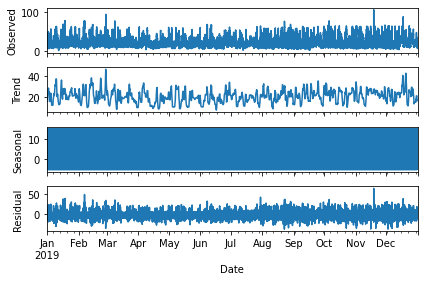

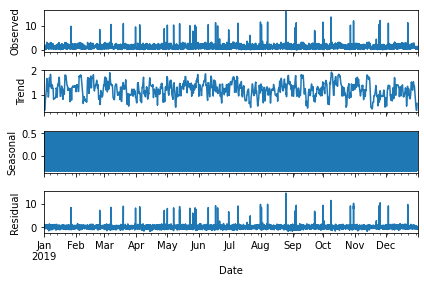

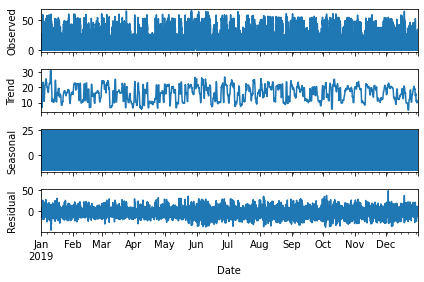

In [13]:
dfCols = df.columns.to_list()
for col in dfCols:
  result = seasonal_decompose(df[col], freq = 1440, model='add')
  result.plot();

### SIMPLER STATS MODELS

#### Train Test Split

In [27]:
train = df[:-43200].copy()
test = df[-43200:].copy()

In [89]:
# Dataframe for testing how well the models fit on training data
trainDataFitTestDf = train.copy()

#### Holt's Method (Double Exponential Smoothing (DES)) And Holt-Winters Method (Triple Exponential Smoothing (TES))

In [142]:
#trainDataFitTestDf['DESadd_z1_Light(kW)'] = ExponentialSmoothing(trainDataFitTestDf['z1_Light(kW)'], trend='add').fit().fittedvalues.shift(-1)
trainDataFitTestDf['TESadd_z1_Light(kW)'] = ExponentialSmoothing(trainDataFitTestDf['z1_Light(kW)'],trend='add',seasonal='add',seasonal_periods=720).fit().fittedvalues
trainDataFitTestDf[['z1_Light(kW)', 'DESadd_z1_Light(kW)', 'TESadd_z1_Light(kW)']].head()

,z1_Light(kW),DESadd_z1_Light(kW),TESadd_z1_Light(kW)
Date,,,
2019-01-01 00:00:00,0.03,0.030028,0.026460
2019-01-01 00:01:00,0.00,0.007213,0.007428
2019-01-01 00:02:00,0.02,0.016960,0.009950
2019-01-01 00:03:00,0.00,0.004084,0.020504
2019-01-01 00:04:00,0.01,0.008605,0.004401


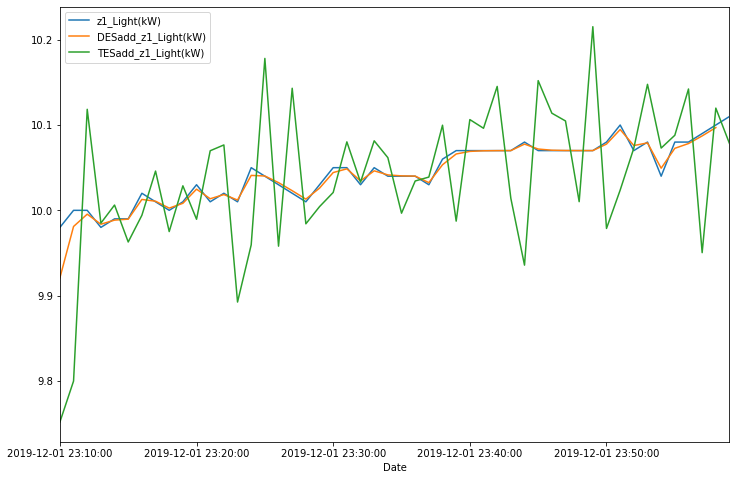

In [93]:
trainDataFitTestDf[['z1_Light(kW)', 'DESadd_z1_Light(kW)', 'TESadd_z1_Light(kW)']].iloc[-50:].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

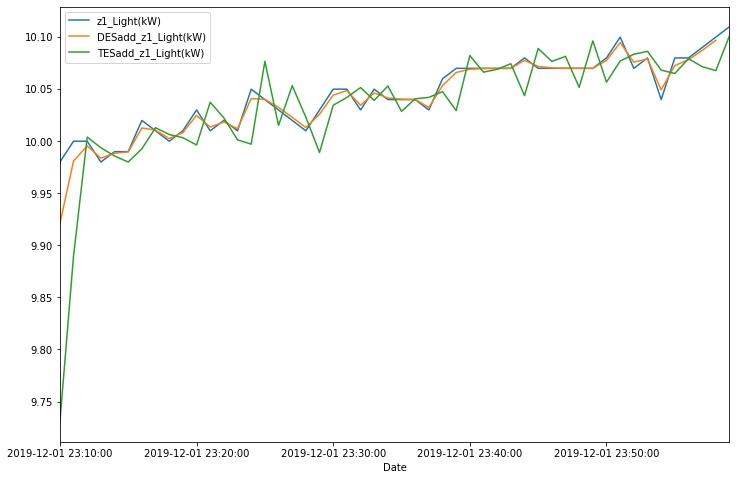

In [146]:
trainDataFitTestDf[['z1_Light(kW)', 'DESadd_z1_Light(kW)', 'TESadd_z1_Light(kW)']].iloc[-50:].plot(figsize=(12,8)).autoscale(axis='x',tight=True);
#trainDataFitTestDf[['z1_Light(kW)', 'TESadd_z1_Light(kW)']].plot(figsize=(50,10)).autoscale(axis='x',tight=True);

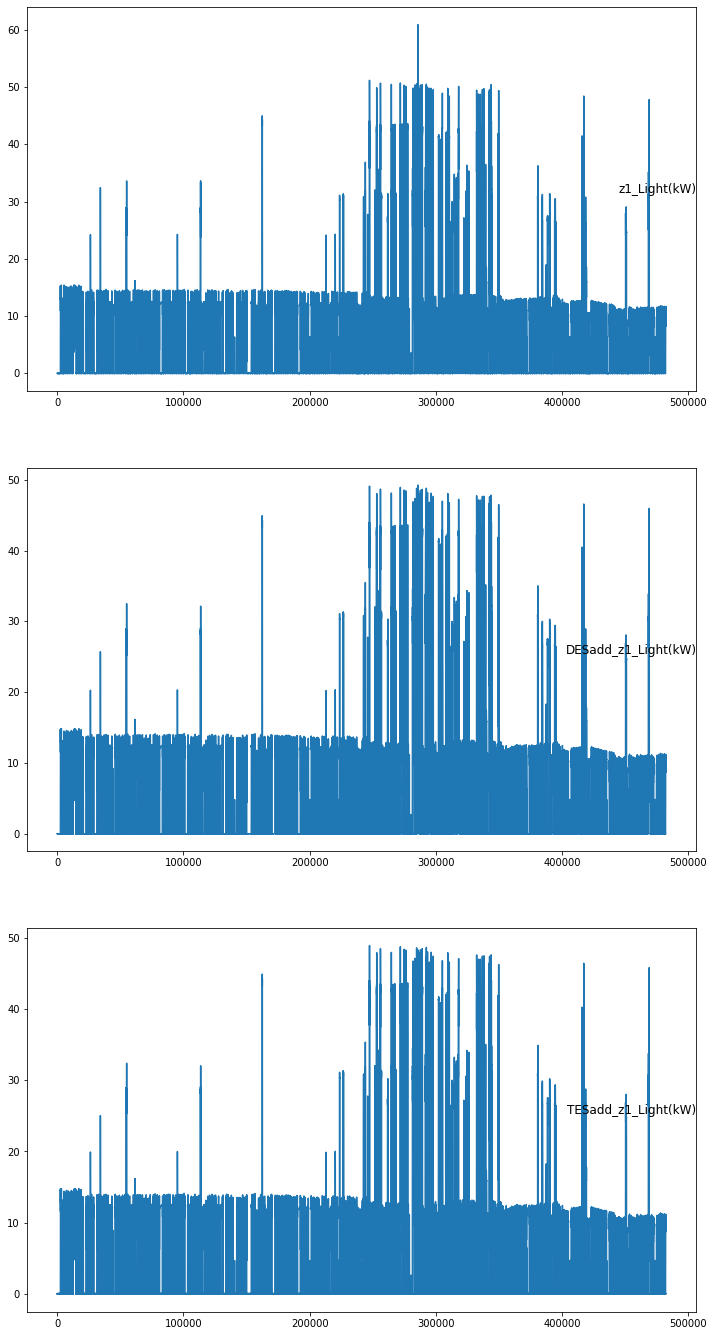

In [144]:
noOfcolumnsToPlot = 3
setFigSize = (12,24)
plotTimeSeriesGraph(trainDataFitTestDf[['z1_Light(kW)', 'DESadd_z1_Light(kW)', 'TESadd_z1_Light(kW)']], noOfcolumnsToPlot, setFigSize)

In [147]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#reqDfCols = reqDf.columns.to_list()
dfCols = df.columns.to_list()

for col in dfCols:
  clear_output(wait=True)

  print(f"Training Model With DES For Column {col}...")
  modelDES = ExponentialSmoothing(train[col], trend='add').fit()
  print(f"Forecasting Test Data With DES Model For Column {col}...")
  test['DESadd_'+col] = modelDES.forecast(steps=43200)

  print(f"Training Model With TES For Column {col}...")
  modelTES = ExponentialSmoothing(train[col],trend='add',seasonal='add',seasonal_periods=720).fit()
  print(f"Forecasting Test Data With TES Model For Column {col}...")
  test['TESadd_'+col] = modelTES.forecast(steps=43200)

Training Model With TES For Column z4_Light(kW)...
Forecasting Test Data With TES Model For Column z4_Light(kW)...


In [148]:
#test.to_csv(datasetsPath+'2019Floor1_DESadd_TESadd_2.csv')

In [72]:
test.head()

,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW),DESadd_z1_Light(kW),TESadd_z1_Light(kW),DESadd_z1_Plug(kW),TESadd_z1_Plug(kW),DESadd_z2_AC1(kW),TESadd_z2_AC1(kW),DESadd_z2_AC2(kW),TESadd_z2_AC2(kW),DESadd_z2_AC3(kW),TESadd_z2_AC3(kW),DESadd_z2_AC4(kW),TESadd_z2_AC4(kW),DESadd_z2_Light(kW),TESadd_z2_Light(kW),DESadd_z2_Plug(kW),TESadd_z2_Plug(kW),DESadd_z3_Light(kW),TESadd_z3_Light(kW),DESadd_z3_Plug(kW),TESadd_z3_Plug(kW),DESadd_z4_Light(kW),TESadd_z4_Light(kW)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-02 00:00:00,10.10,0.00,46.44,0.02,0.01,0.01,5.39,24.74,11.07,0.55,20.01,10.106900,10.138773,0.01,-0.035875,48.280106,40.947584,0.02,0.191142,0.009856,0.008927,0.00494,0.005910,5.418328,5.323888,24.696951,25.044390,11.068558,9.851730,0.541611,0.552914,20.011257,19.649482
2019-12-02 00:01:00,10.12,0.02,47.01,0.02,0.01,0.00,5.41,24.64,11.07,0.54,20.00,10.106922,10.134166,0.01,-0.100020,48.280213,45.729564,0.02,0.190798,0.009899,0.008757,0.00494,0.004329,5.418328,5.337242,24.696976,25.036418,11.068560,9.168141,0.541611,0.541059,20.011280,19.980371
2019-12-02 00:02:00,10.11,0.00,44.47,0.02,0.02,0.01,5.39,17.53,11.04,0.55,20.05,10.106944,10.175438,0.01,-0.188007,48.280319,47.032042,0.02,0.123334,0.009942,0.009257,0.00494,0.006942,5.418328,5.341211,24.697000,25.691748,11.068561,8.401602,0.541611,0.537431,20.011302,20.037981
2019-12-02 00:03:00,10.11,0.01,2.18,0.02,0.00,0.00,5.40,14.77,11.07,0.55,19.99,10.106967,10.187572,0.01,-0.273474,48.280426,54.793260,0.02,-0.060020,0.009986,0.008630,0.00494,0.005289,5.418328,5.344231,24.697025,24.453790,11.068563,7.681346,0.541611,0.539050,20.011324,20.134360
2019-12-02 00:04:00,10.10,0.02,2.18,0.03,0.01,0.00,5.40,14.36,11.09,0.54,20.01,10.106989,10.162990,0.01,-0.352578,48.280532,56.597181,0.02,-0.502686,0.010029,0.010315,0.00494,0.005163,5.418328,5.345346,24.697050,23.233244,11.068564,6.885709,0.541611,0.535796,20.011347,20.163408


#### Evaluate DES and TES Results

In [164]:
for col in dfCols:
  RMSE_DES = rmse(test[col], test['DESadd_'+col])
  RMSE_TES = rmse(test[col], test['TESadd_'+col])
  print(f'For Column {col}:')
  print(f'DES RMSE: {RMSE_DES:.3f}')
  print(f'TES RMSE: {RMSE_TES:.3f}')
  print("\n")

For Column z1_Light(kW):
DES RMSE: 8.448
TES RMSE: 8.378


For Column z1_Plug(kW):
DES RMSE: 0.394
TES RMSE: 6.663


For Column z2_AC1(kW):
DES RMSE: 35.652
TES RMSE: 8560.173


For Column z2_AC2(kW):
DES RMSE: 6.561
TES RMSE: 84.990


For Column z2_AC3(kW):
DES RMSE: 1.081
TES RMSE: 0.201


For Column z2_AC4(kW):
DES RMSE: 0.006
TES RMSE: 0.008


For Column z2_Light(kW):
DES RMSE: 2.363
TES RMSE: 2.491


For Column z2_Plug(kW):
DES RMSE: 11.114
TES RMSE: 106.929


For Column z3_Light(kW):
DES RMSE: 17.246
TES RMSE: 21.918


For Column z3_Plug(kW):
DES RMSE: 0.872
TES RMSE: 0.867


For Column z4_Light(kW):
DES RMSE: 16.537
TES RMSE: 3936.496




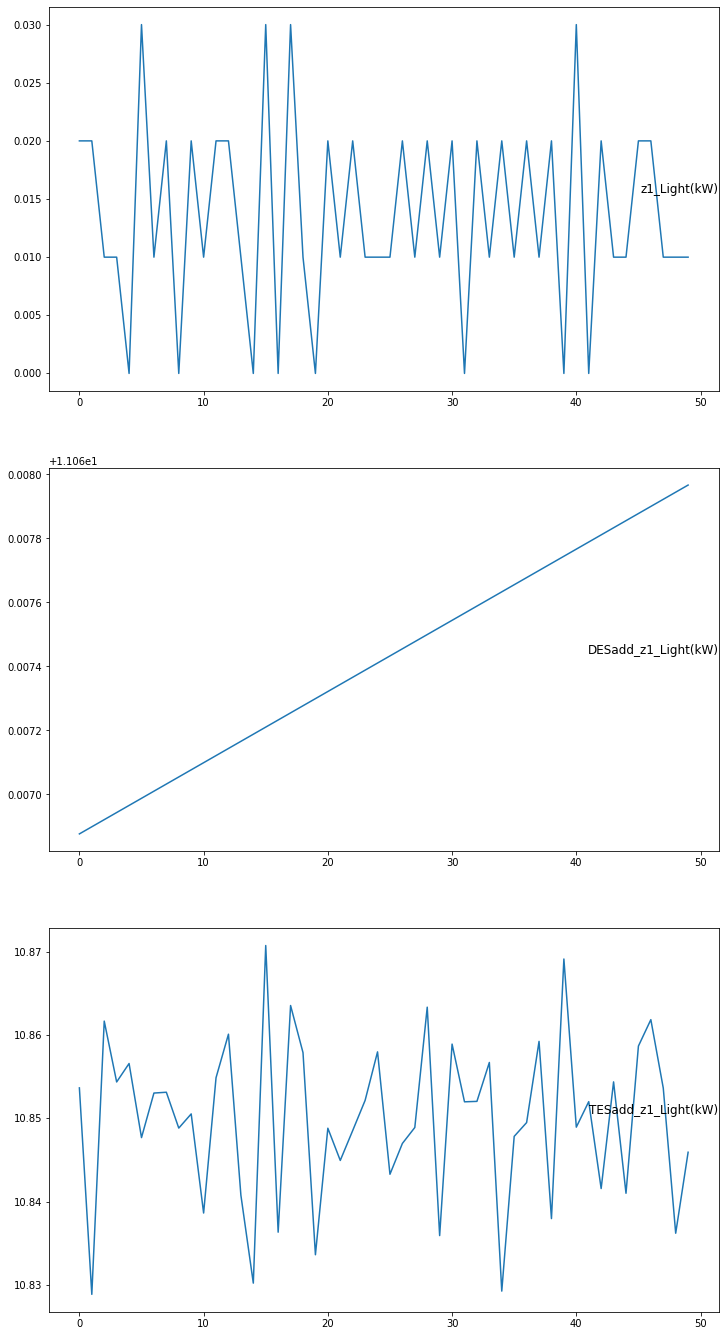

In [168]:
noOfcolumnsToPlot = 3
setFigSize = (12,24)
plotTimeSeriesGraph(test[['z1_Light(kW)', 'DESadd_z1_Light(kW)', 'TESadd_z1_Light(kW)']].iloc[-50:], noOfcolumnsToPlot, setFigSize)

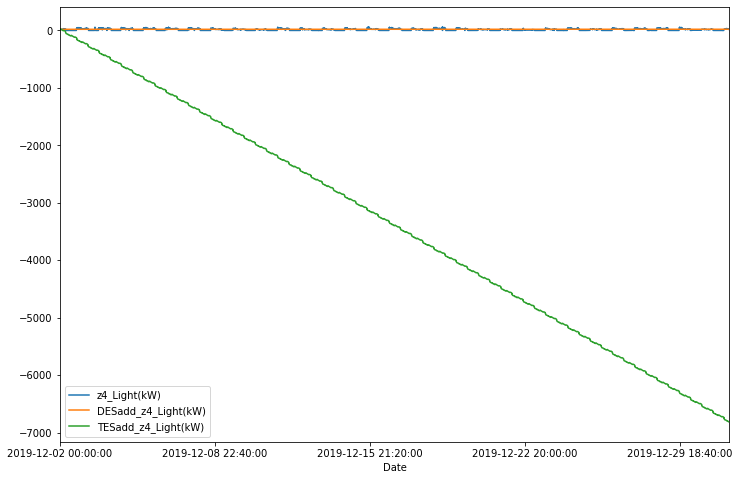

In [160]:
test[['z4_Light(kW)', 'DESadd_z4_Light(kW)', 'TESadd_z4_Light(kW)']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

### COMPLEX STATS MODELS (ARIMA)

#### Perform ADF Test To Check For Stationary

In [42]:
dfColumns = df.columns.to_list()
for col in dfColumns:
  adf_test(df[col][-1440*60:],title=col)
  print("\n")

Augmented Dickey-Fuller Test: z1_Light(kW)
ADF test statistic     -1.037917e+01
p-value                 2.161542e-18
# lags used             5.100000e+01
# observations          8.634800e+04
critical value (1%)    -3.430426e+00
critical value (5%)    -2.861573e+00
critical value (10%)   -2.566788e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: z1_Plug(kW)
ADF test statistic        -26.567879
p-value                     0.000000
# lags used                66.000000
# observations          86333.000000
critical value (1%)        -3.430426
critical value (5%)        -2.861573
critical value (10%)       -2.566788
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: z2_AC1(kW)
ADF test statistic     -1.217215e+01
p-value                 1.412758e-22
# lags used             6.400000e+01
# observations     

In [13]:
train = df[-1440*60:-1440*30].copy()
test = df[-1440*30:].copy()

In [9]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults

In [17]:
allTestResultDf = pd.read_csv(datasetsPath+'2019Floor1_DESadd_TESadd_2.csv')
allTestResultDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 43200 non-null  object 
 1   z1_Light(kW)         43200 non-null  float64
 2   z1_Plug(kW)          43200 non-null  float64
 3   z2_AC1(kW)           43200 non-null  float64
 4   z2_AC2(kW)           43200 non-null  float64
 5   z2_AC3(kW)           43200 non-null  float64
 6   z2_AC4(kW)           43200 non-null  float64
 7   z2_Light(kW)         43200 non-null  float64
 8   z2_Plug(kW)          43200 non-null  float64
 9   z3_Light(kW)         43200 non-null  float64
 10  z3_Plug(kW)          43200 non-null  float64
 11  z4_Light(kW)         43200 non-null  float64
 12  DESadd_z1_Light(kW)  43200 non-null  float64
 13  TESadd_z1_Light(kW)  43200 non-null  float64
 14  DESadd_z1_Plug(kW)   43200 non-null  float64
 15  TESadd_z1_Plug(kW)   43200 non-null 

#### Train ARIMA Model For Every Column And Predict Values

In [19]:
for col in dfColumns:
  clear_output(wait=True)
  print(f"Training Model With ARIMA For Column {col}...")
  autoArimaModel = auto_arima(train[col][-1440*2:],maxiter=1000)
  #arimaOrder = autoArimaResult.get_params()['order']
  print(f"Predicting With ARIMA For Column {col}...")
  allTestResultDf['ARIMA_'+col] = autoArimaModel.predict(n_periods=43200)

Training Model With ARIMA For Column z4_Light(kW)...
Predicting With ARIMA For Column z4_Light(kW)...


In [20]:
allTestResultDf.head()

,Date,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW),DESadd_z1_Light(kW),TESadd_z1_Light(kW),DESadd_z1_Plug(kW),TESadd_z1_Plug(kW),DESadd_z2_AC1(kW),TESadd_z2_AC1(kW),DESadd_z2_AC2(kW),TESadd_z2_AC2(kW),DESadd_z2_AC3(kW),TESadd_z2_AC3(kW),DESadd_z2_AC4(kW),TESadd_z2_AC4(kW),DESadd_z2_Light(kW),TESadd_z2_Light(kW),DESadd_z2_Plug(kW),TESadd_z2_Plug(kW),DESadd_z3_Light(kW),TESadd_z3_Light(kW),DESadd_z3_Plug(kW),TESadd_z3_Plug(kW),DESadd_z4_Light(kW),TESadd_z4_Light(kW),ARIMA_z1_Light(kW),ARIMA_z1_Plug(kW),ARIMA_z2_AC1(kW),ARIMA_z2_AC2(kW),ARIMA_z2_AC3(kW),ARIMA_z2_AC4(kW),ARIMA_z2_Light(kW),ARIMA_z2_Plug(kW),ARIMA_z3_Light(kW),ARIMA_z3_Plug(kW),ARIMA_z4_Light(kW)
0,2019-12-02 00:00:00,10.10,0.00,46.44,0.02,0.01,0.01,5.39,24.74,11.07,0.55,20.01,10.106900,10.124767,0.01,0.017416,48.280106,44.770110,0.02,-0.185752,0.009856,0.008401,0.00494,0.004782,5.418328,5.327508,24.696951,25.312333,11.068558,11.029640,0.541611,0.539182,20.011257,20.186585,10.106773,0.009224,52.087767,0.022782,0.008582,0.002773,5.421145,21.820225,11.068850,0.544837,20.012417
1,2019-12-02 00:01:00,10.12,0.02,47.01,0.02,0.01,0.00,5.41,24.64,11.07,0.54,20.00,10.106922,10.103229,0.01,0.057527,48.280213,44.526553,0.02,-0.324754,0.009899,0.009246,0.00494,0.004901,5.418328,5.353102,24.696976,24.644182,11.068560,11.123110,0.541611,0.538111,20.011280,20.674451,10.108551,0.007653,47.976091,0.022782,0.008749,0.005879,5.419735,20.184477,11.068718,0.543569,20.014056
2,2019-12-02 00:02:00,10.11,0.00,44.47,0.02,0.02,0.01,5.39,17.53,11.04,0.55,20.05,10.106944,10.111210,0.01,0.100986,48.280319,44.229854,0.02,-0.443085,0.009942,0.008676,0.00494,0.004718,5.418328,5.386623,24.697000,25.397692,11.068561,11.119894,0.541611,0.536726,20.011302,20.947074,10.107300,0.008566,30.784781,0.022782,0.008749,0.003923,5.412791,18.881087,11.068702,0.543569,20.014936
3,2019-12-02 00:03:00,10.11,0.01,2.18,0.02,0.00,0.00,5.40,14.77,11.07,0.55,19.99,10.106967,10.114451,0.01,0.159585,48.280426,46.288529,0.02,-0.509569,0.009986,0.008607,0.00494,0.006412,5.418328,5.382200,24.697025,25.132539,11.068563,11.105921,0.541611,0.537539,20.011324,21.193959,10.107956,0.007737,18.536454,0.022782,0.008749,0.004670,5.408040,17.934171,11.068701,0.543569,20.015409
4,2019-12-02 00:04:00,10.10,0.02,2.18,0.03,0.01,0.00,5.40,14.36,11.09,0.54,20.01,10.106989,10.113310,0.01,0.194044,48.280532,48.331727,0.02,-0.488473,0.010029,0.009099,0.00494,0.003676,5.418328,5.445223,24.697050,24.455427,11.068564,11.104310,0.541611,0.539076,20.011347,21.283895,10.107926,0.008355,9.704468,0.022782,0.008749,0.004207,5.406459,17.231148,11.068701,0.543569,20.015663


In [21]:
allTestResultDf.to_csv(datasetsPath+'PredictionForTest_DES_TES_ARIMA.csv')

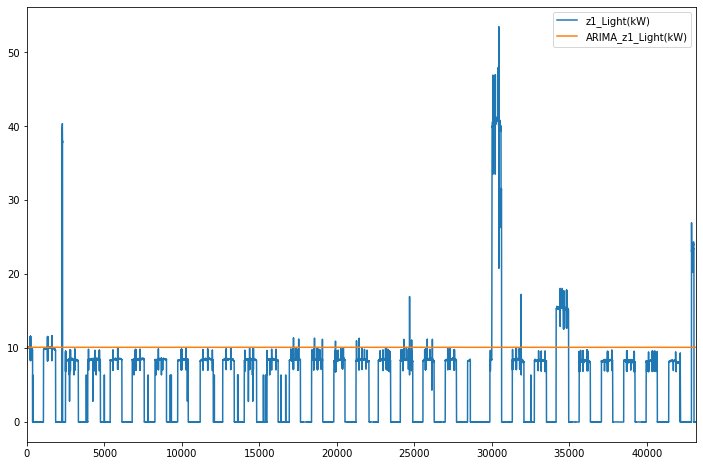

In [25]:
allTestResultDf[['z1_Light(kW)', 'ARIMA_z1_Light(kW)']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

### ALL MODEL EVALUATION AND COMPARISON

#### Combine All Model Results (DES, TES, ARIMA, VAR, LSTM)

In [26]:
LSTMresults = pd.read_csv(datasetsPath+'LSTMPredictionFor30Days.csv')
VARResults = pd.read_csv(datasetsPath+'Forecast_30Days_VAR(15)_VARMA.csv')

In [31]:
LSTMresults.drop('Date', axis=1, inplace=True)
VARResults.drop('Unnamed: 0', axis=1, inplace=True)

In [32]:
LSTMresults.columns = ['LSTM_z1_Light(kW)', 'LSTM_z1_Plug(kW)', 'LSTM_z2_AC1(kW)', 'LSTM_z2_AC2(kW)', 
                       'LSTM_z2_AC3(kW)', 'LSTM_z2_AC4(kW)', 'LSTM_z2_Light(kW)', 'LSTM_z2_Plug(kW)', 
                       'LSTM_z3_Light(kW)', 'LSTM_z3_Plug(kW)', 'LSTM_z4_Light(kW)']
                       
VARResults.columns = ['VAR_z1_Light(kW)', 'VAR_z1_Plug(kW)', 'VAR_z2_AC1(kW)', 'VAR_z2_AC2(kW)', 
                      'VAR_z2_AC3(kW)', 'VAR_z2_AC4(kW)', 'VAR_z2_Light(kW)', 'VAR_z2_Plug(kW)', 
                      'VAR_z3_Light(kW)', 'VAR_z3_Plug(kW)', 'VAR_z4_Light(kW)']
                      
LSTMresults.info();
VARResults.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LSTM_z1_Light(kW)  43200 non-null  float64
 1   LSTM_z1_Plug(kW)   43200 non-null  float64
 2   LSTM_z2_AC1(kW)    43200 non-null  float64
 3   LSTM_z2_AC2(kW)    43200 non-null  float64
 4   LSTM_z2_AC3(kW)    43200 non-null  float64
 5   LSTM_z2_AC4(kW)    43200 non-null  float64
 6   LSTM_z2_Light(kW)  43200 non-null  float64
 7   LSTM_z2_Plug(kW)   43200 non-null  float64
 8   LSTM_z3_Light(kW)  43200 non-null  float64
 9   LSTM_z3_Plug(kW)   43200 non-null  float64
 10  LSTM_z4_Light(kW)  43200 non-null  float64
dtypes: float64(11)
memory usage: 3.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   VAR_z1_Light(kW)  

In [33]:
AllTestForecastResultsDf = pd.concat([allTestResultDf, LSTMresults, VARResults], axis=1)
AllTestForecastResultsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 43200 non-null  object 
 1   z1_Light(kW)         43200 non-null  float64
 2   z1_Plug(kW)          43200 non-null  float64
 3   z2_AC1(kW)           43200 non-null  float64
 4   z2_AC2(kW)           43200 non-null  float64
 5   z2_AC3(kW)           43200 non-null  float64
 6   z2_AC4(kW)           43200 non-null  float64
 7   z2_Light(kW)         43200 non-null  float64
 8   z2_Plug(kW)          43200 non-null  float64
 9   z3_Light(kW)         43200 non-null  float64
 10  z3_Plug(kW)          43200 non-null  float64
 11  z4_Light(kW)         43200 non-null  float64
 12  DESadd_z1_Light(kW)  43200 non-null  float64
 13  TESadd_z1_Light(kW)  43200 non-null  float64
 14  DESadd_z1_Plug(kW)   43200 non-null  float64
 15  TESadd_z1_Plug(kW)   43200 non-null 

In [38]:
AllTestForecastResultsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 67 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 43200 non-null  object 
 1   z1_Light(kW)         43200 non-null  float64
 2   z1_Plug(kW)          43200 non-null  float64
 3   z2_AC1(kW)           43200 non-null  float64
 4   z2_AC2(kW)           43200 non-null  float64
 5   z2_AC3(kW)           43200 non-null  float64
 6   z2_AC4(kW)           43200 non-null  float64
 7   z2_Light(kW)         43200 non-null  float64
 8   z2_Plug(kW)          43200 non-null  float64
 9   z3_Light(kW)         43200 non-null  float64
 10  z3_Plug(kW)          43200 non-null  float64
 11  z4_Light(kW)         43200 non-null  float64
 12  DESadd_z1_Light(kW)  43200 non-null  float64
 13  TESadd_z1_Light(kW)  43200 non-null  float64
 14  DESadd_z1_Plug(kW)   43200 non-null  float64
 15  TESadd_z1_Plug(kW)   43200 non-null 

In [39]:
AllTestForecastResultsDf.to_csv(datasetsPath+'AllTestResultFinal.csv')

#### Determine The Best Model Which Has The LEAST RMSE Value For Majority Of The Columns

In [36]:
for col in dfColumns:
  
  RMSE_DES = rmse(AllTestForecastResultsDf[col], AllTestForecastResultsDf['DESadd_'+col])
  RMSE_TES = rmse(AllTestForecastResultsDf[col], AllTestForecastResultsDf['TESadd_'+col])
  RMSE_ARIMA = rmse(AllTestForecastResultsDf[col], AllTestForecastResultsDf['ARIMA_'+col])
  RMSE_VAR = rmse(AllTestForecastResultsDf[col], AllTestForecastResultsDf['VAR_'+col])
  RMSE_LSTM = rmse(AllTestForecastResultsDf[col], AllTestForecastResultsDf['LSTM_'+col])
  print(f'For Column {col}:')
  print(f'DES RMSE: {RMSE_DES:.3f}')
  print(f'TES RMSE: {RMSE_TES:.3f}')
  print(f'ARIMA RMSE: {RMSE_ARIMA:.3f}')
  print(f'VAR RMSE: {RMSE_VAR:.3f}')
  print(f'LSTM RMSE: {RMSE_LSTM:.3f}')
  print("\n")

For Column z1_Light(kW):
DES RMSE: 8.448
TES RMSE: 8.378
ARIMA RMSE: 8.140
VAR RMSE: 6.497
LSTM RMSE: 9.074


For Column z1_Plug(kW):
DES RMSE: 0.394
TES RMSE: 6.663
ARIMA RMSE: 0.394
VAR RMSE: 1.685
LSTM RMSE: 3.073


For Column z2_AC1(kW):
DES RMSE: 35.652
TES RMSE: 8560.173
ARIMA RMSE: 23.110
VAR RMSE: 22.354
LSTM RMSE: 21.872


For Column z2_AC2(kW):
DES RMSE: 6.561
TES RMSE: 84.990
ARIMA RMSE: 6.560
VAR RMSE: 7.795
LSTM RMSE: 6.652


For Column z2_AC3(kW):
DES RMSE: 1.081
TES RMSE: 0.201
ARIMA RMSE: 0.005
VAR RMSE: 0.005
LSTM RMSE: 0.005


For Column z2_AC4(kW):
DES RMSE: 0.006
TES RMSE: 0.008
ARIMA RMSE: 0.006
VAR RMSE: 0.006
LSTM RMSE: 0.007


For Column z2_Light(kW):
DES RMSE: 2.363
TES RMSE: 2.491
ARIMA RMSE: 2.370
VAR RMSE: 2.529
LSTM RMSE: 2.832


For Column z2_Plug(kW):
DES RMSE: 11.114
TES RMSE: 106.929
ARIMA RMSE: 5.160
VAR RMSE: 5.185
LSTM RMSE: 5.487


For Column z3_Light(kW):
DES RMSE: 17.246
TES RMSE: 21.918
ARIMA RMSE: 17.267
VAR RMSE: 12.858
LSTM RMSE: 20.704


For 

From The above RMSE values for all the models (DES, TES, ARIMA, VAR, LSTM) VAR and ARIMA both seemed to be performing equally good. Hence, we will forecast future values of this dataset using VAR(15) model.

#### Visualize All Test Data Predictions

In [4]:
AllPredictionDf = pd.read_csv(datasetsPath+'AllTestResultFinal.csv')

##### Visualize Simple Stats Model Results

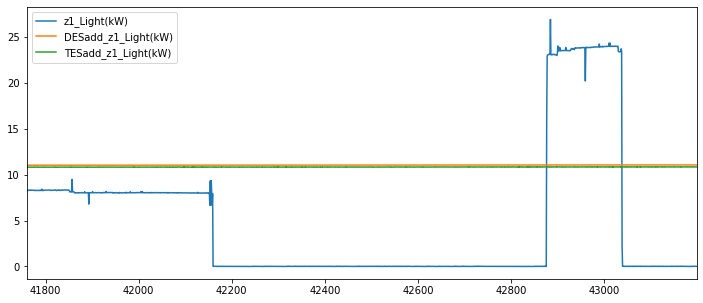

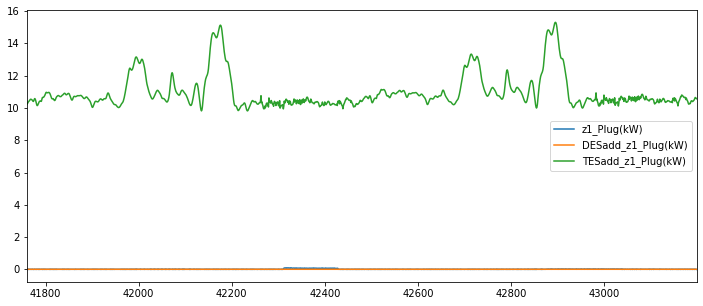

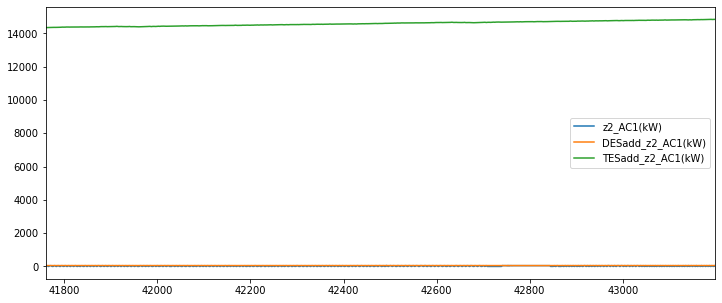

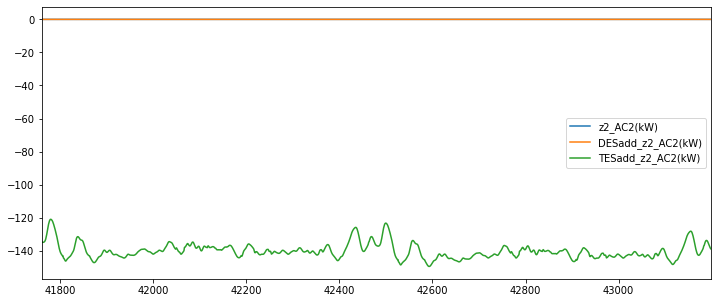

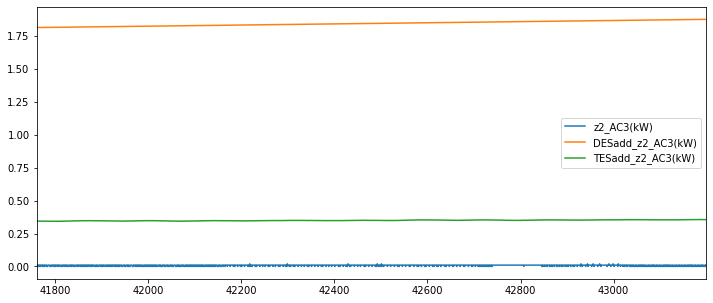

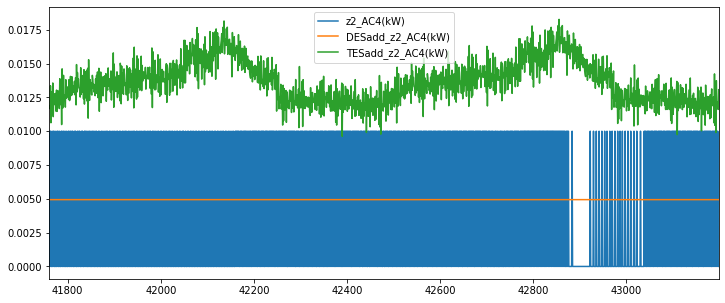

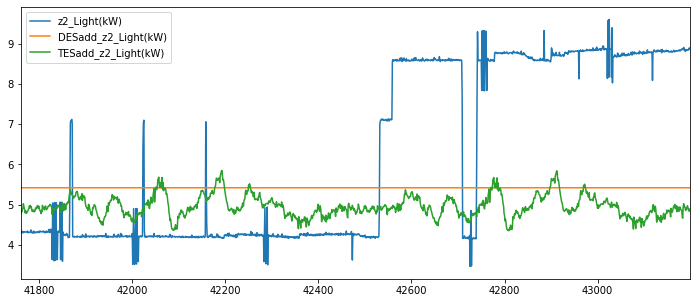

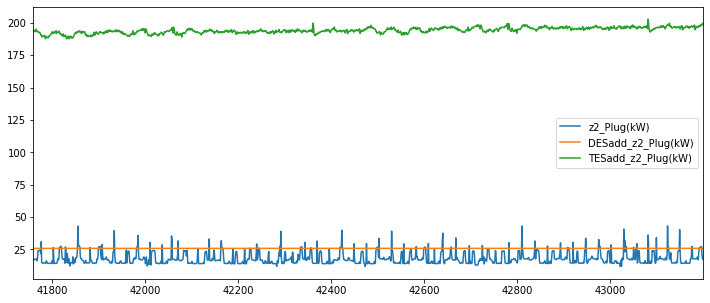

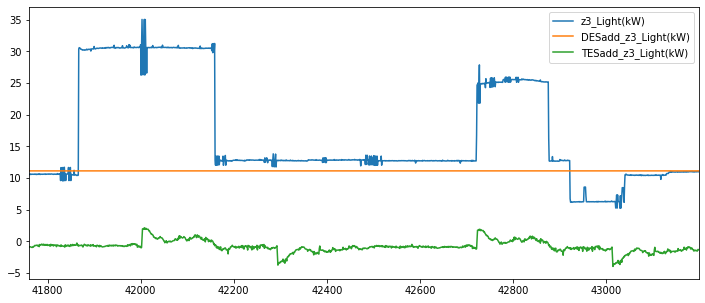

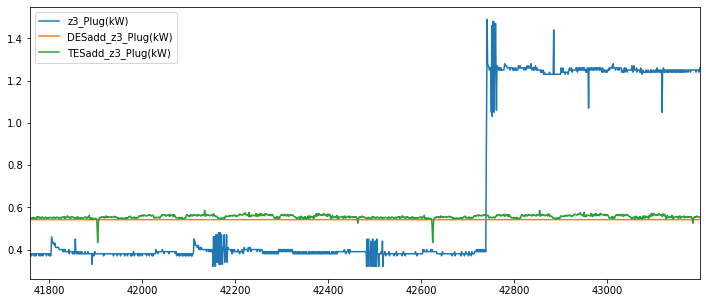

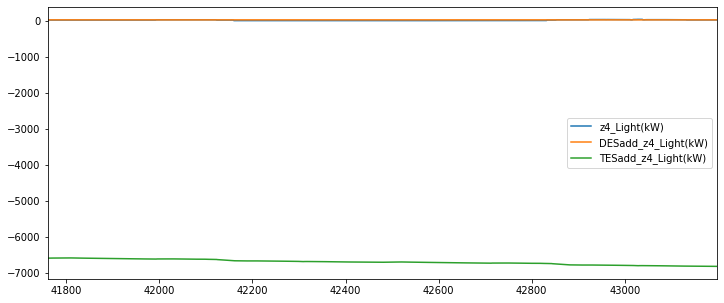

In [9]:
dfColumns = df.columns.to_list()
for col in dfColumns:
  AllPredictionDf[[col, 'DESadd_'+col, 'TESadd_'+col]].iloc[-1440:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
  plt.show();

##### Visualize Complex Statistical Models

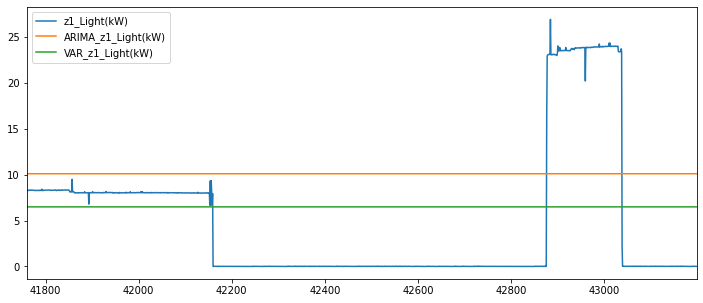

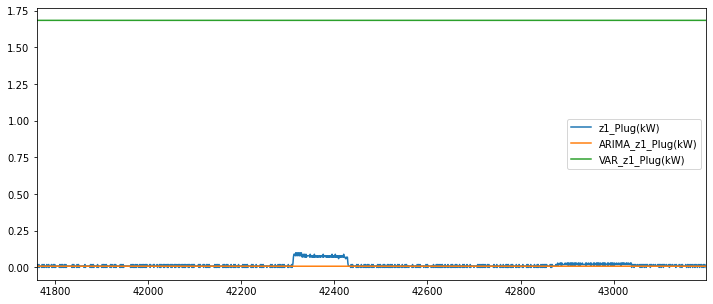

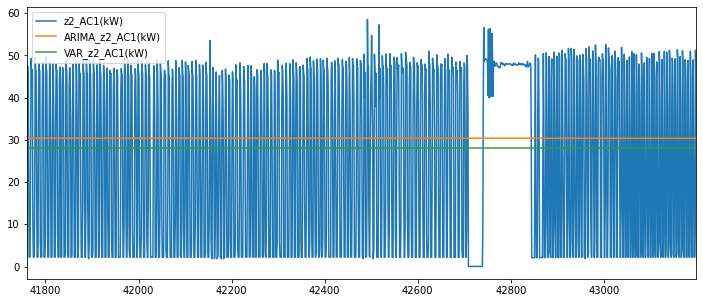

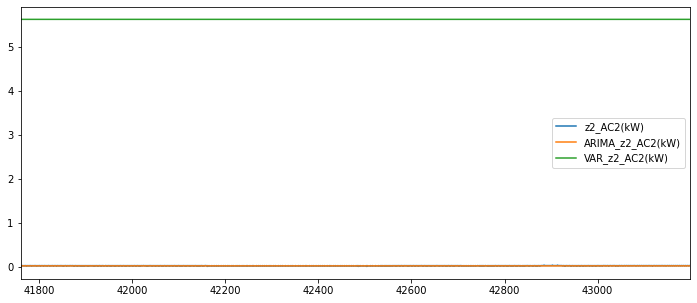

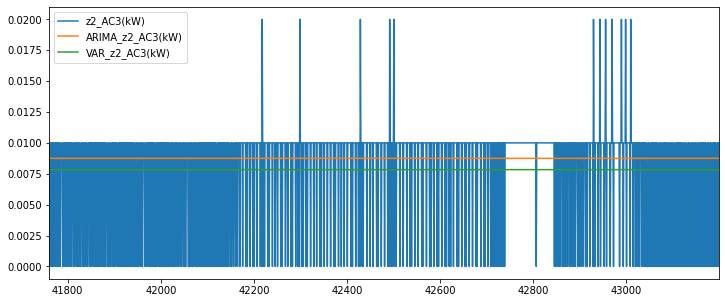

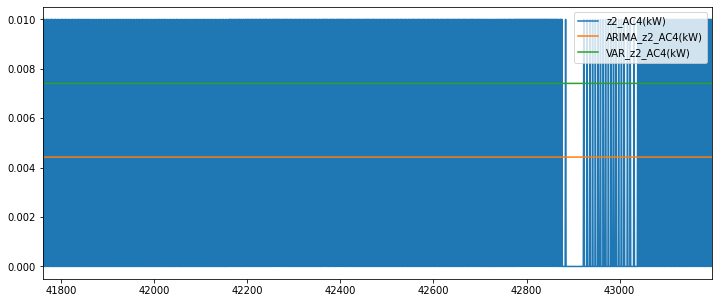

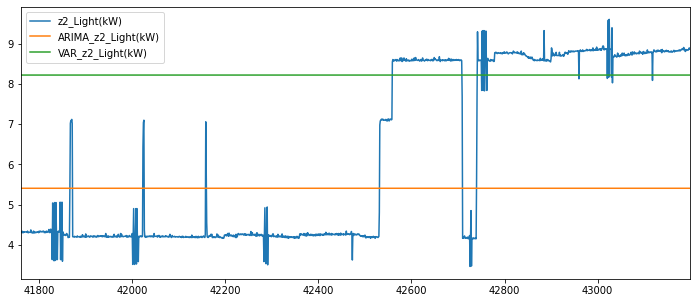

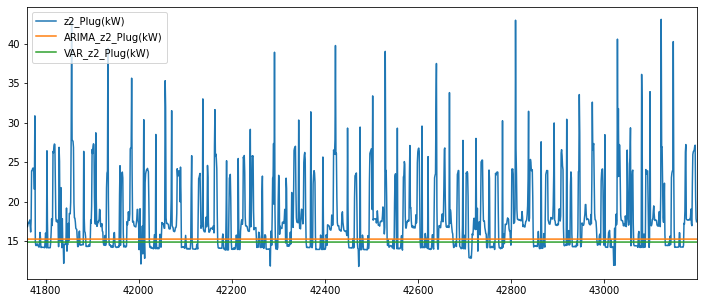

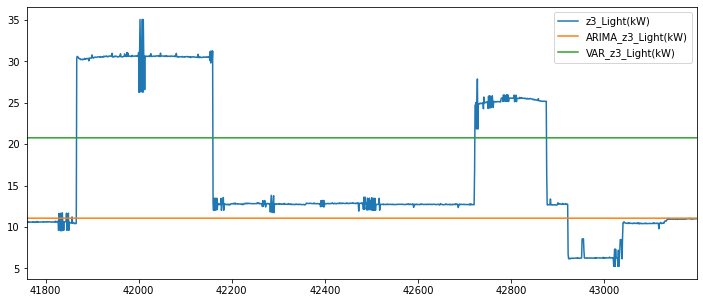

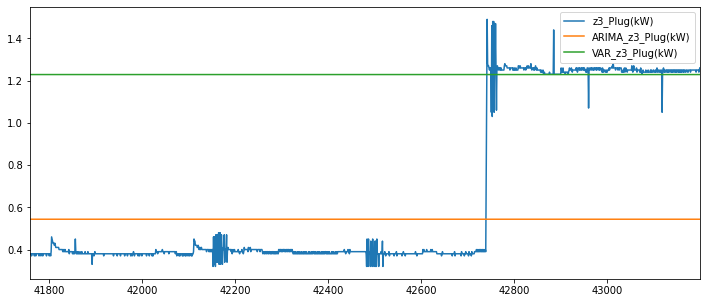

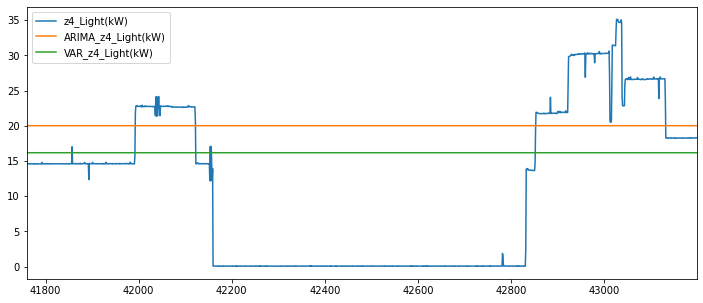

In [10]:
dfColumns = df.columns.to_list()
for col in dfColumns:
  AllPredictionDf[[col, 'ARIMA_'+col, 'VAR_'+col]].iloc[-1440:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
  plt.show();

##### Visualize LSTM Model 

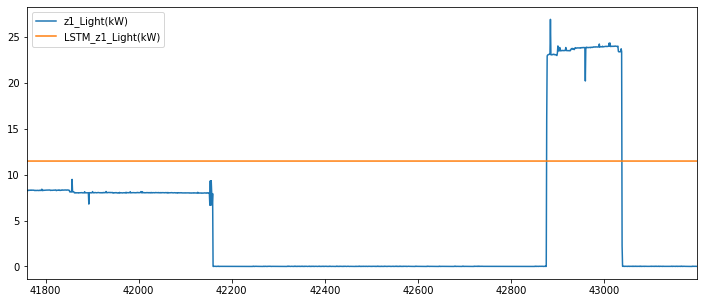

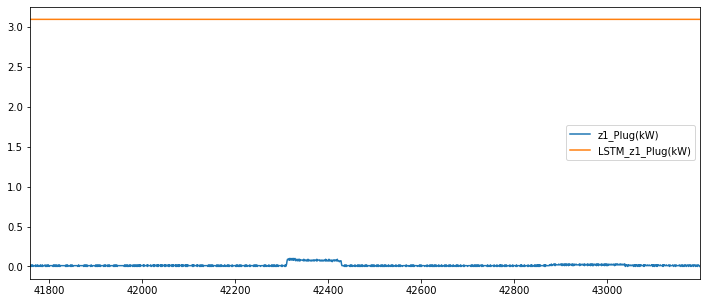

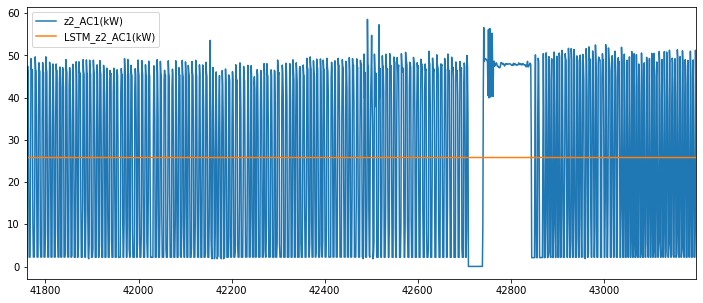

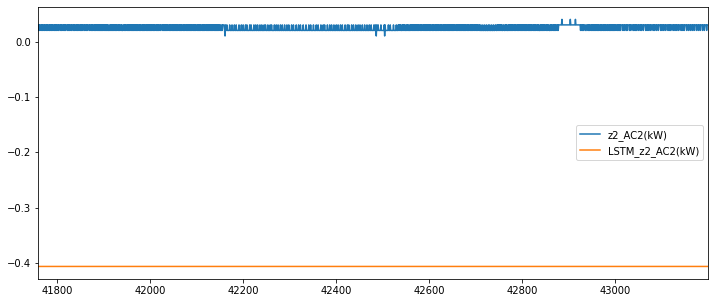

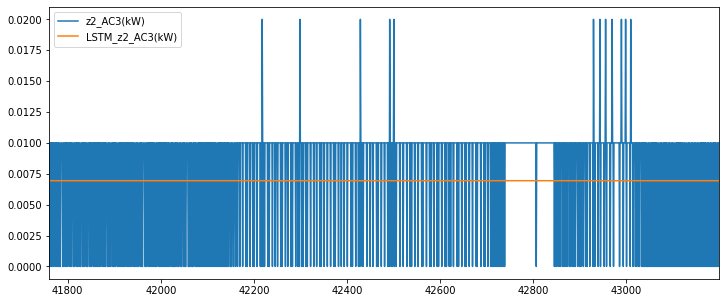

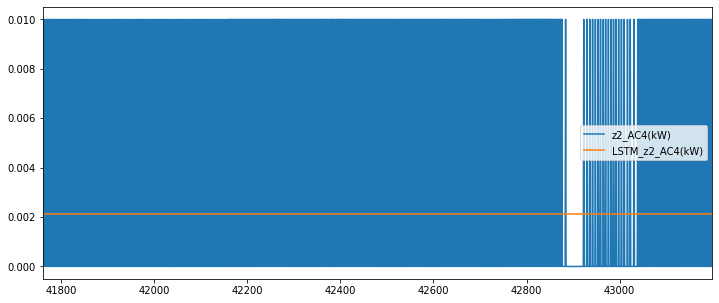

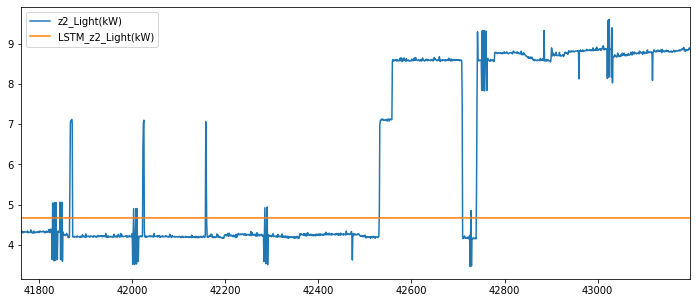

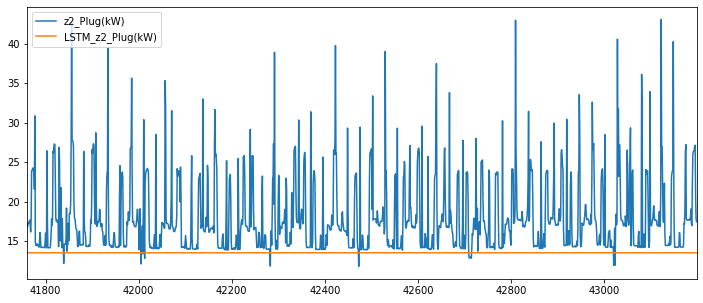

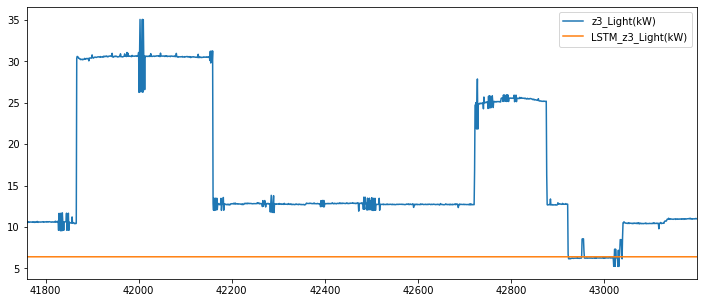

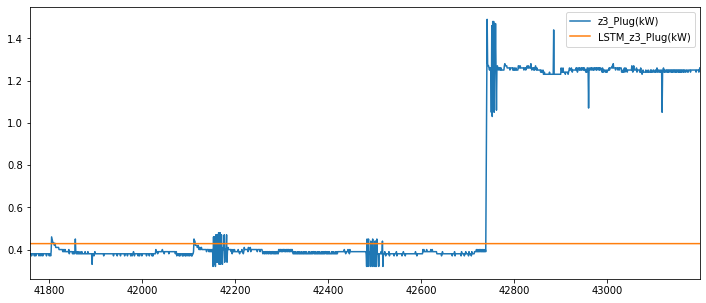

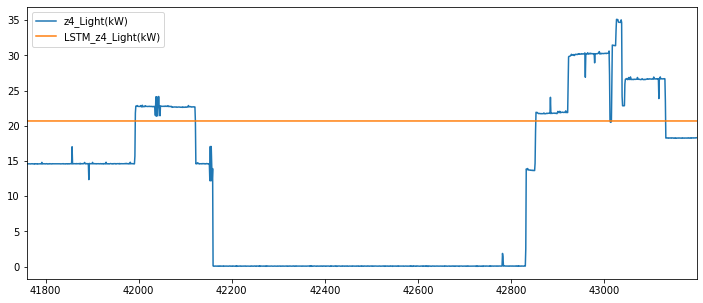

In [11]:
dfColumns = df.columns.to_list()
for col in dfColumns:
  AllPredictionDf[[col, 'LSTM_'+col]].iloc[-1440:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
  plt.show();

##### Visualize All Data

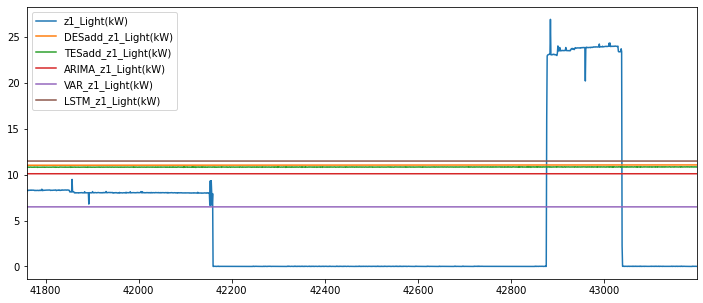

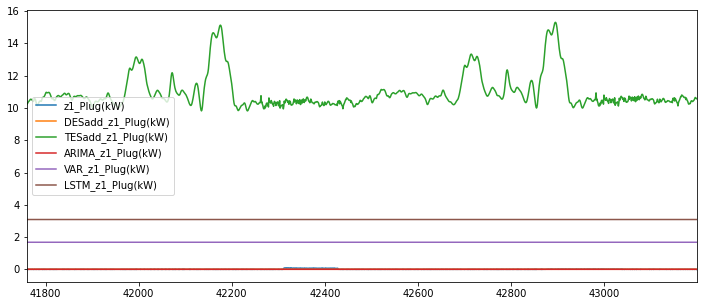

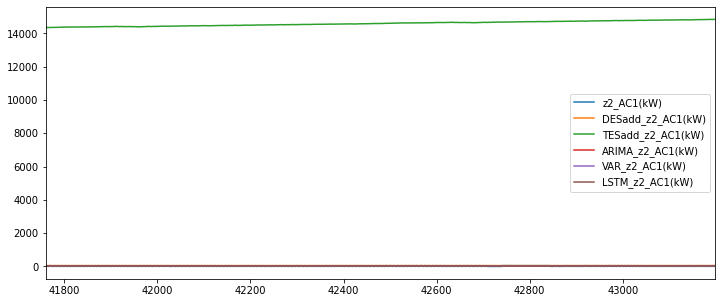

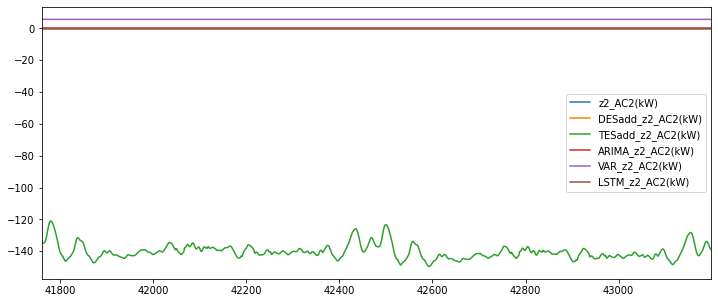

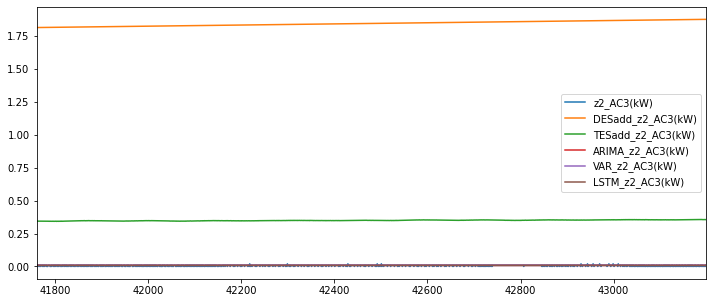

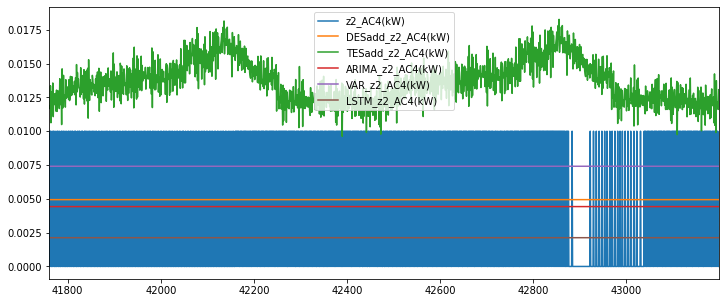

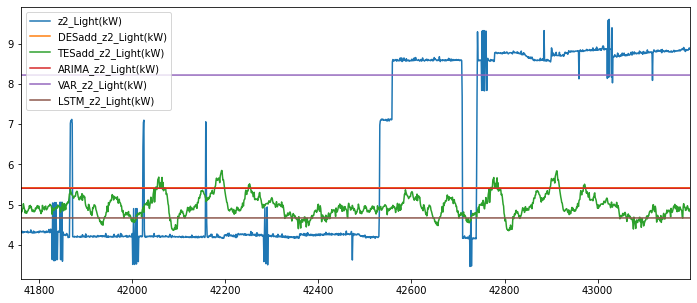

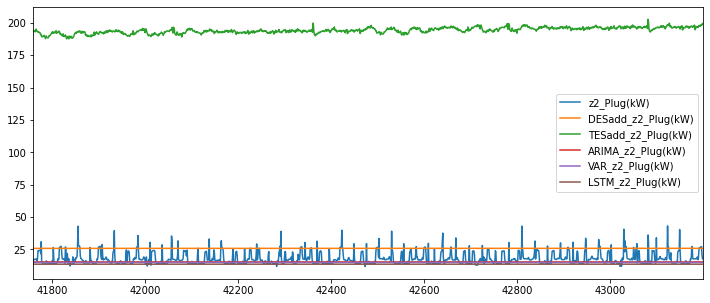

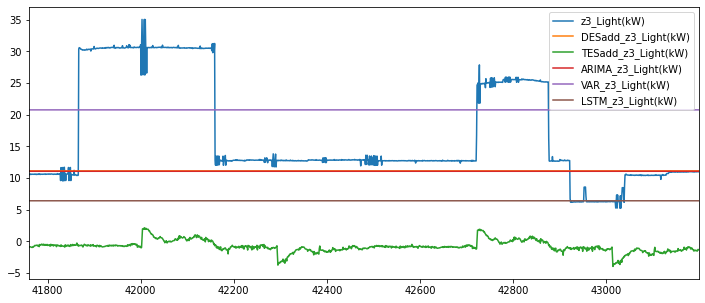

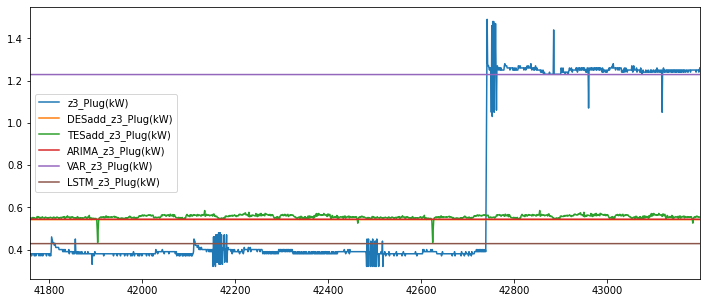

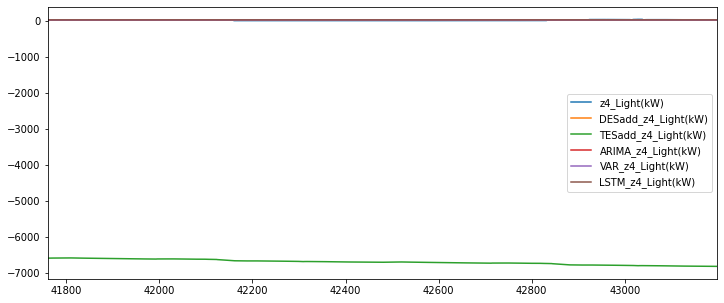

In [41]:
dfColumns = df.columns.to_list()
for col in dfColumns:
  AllTestForecastResultsDf[[col, 'DESadd_'+col, 'TESadd_'+col, 'ARIMA_'+col,
                            'VAR_'+col, 'LSTM_'+col]].iloc[-1440:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
  plt.show();